In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split 
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load Tweet dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Twitter_Data.csv')
# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
# Check for missing data
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [ ]:
# dimensionality of the data
df.shape

(162969, 2)

In [ ]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


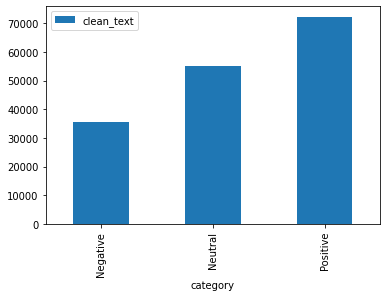

In [ ]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

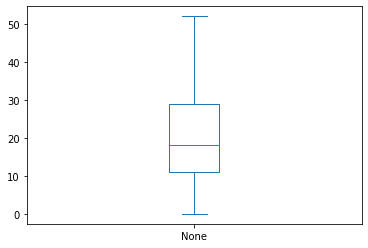

In [ ]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

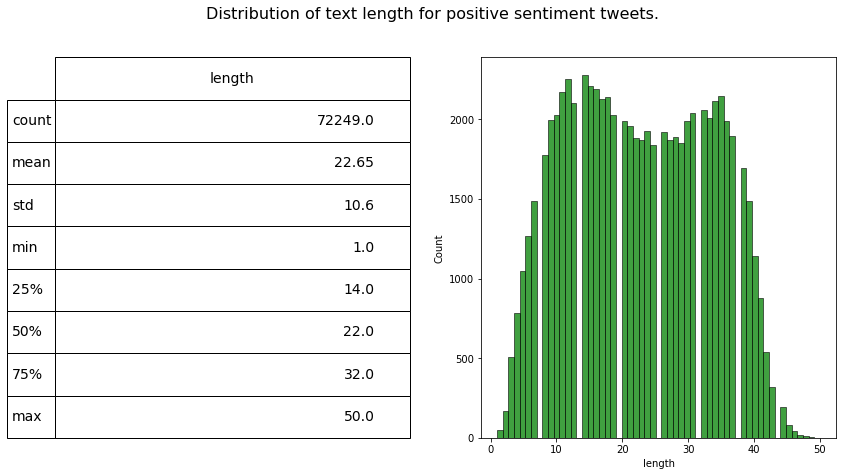

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

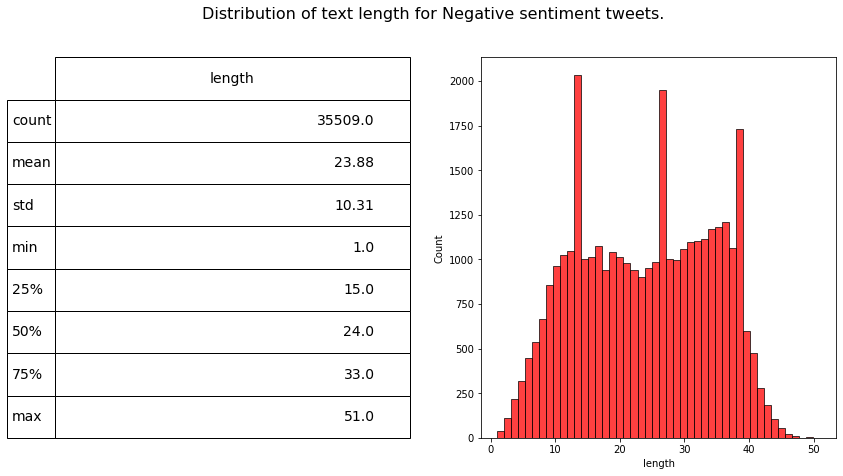

In [ ]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

In [ ]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

    # Positive tweet words
    wordcount_gen(df, 'Positive')

    # Negative tweet words
    wordcount_gen(df, 'Negative')

    # Neutral tweet words
    wordcount_gen(df, 'Neutral')


In [ ]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [ ]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [ ]:
print(X[0])
print(Y[0])

['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']
0


In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


vocabulary_size = 500

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                                  
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [ ]:
# print first 200 words/tokens
print(count_vector.get_feature_names_out()[0:200])

['100', '2012', '2014', '2019', 'aap', 'abl', 'abus', 'accept', 'account', 'achiev', 'act', 'action', 'actual', 'address', 'agenda', 'agre', 'ahead', 'air', 'allow', 'alreadi', 'also', 'alway', 'ambani', 'amit', 'announc', 'anoth', 'answer', 'anti', 'antisatellit', 'anyon', 'anyth', 'app', 'armi', 'around', 'asat', 'ask', 'attack', 'aur', 'away', 'back', 'bad', 'bail', 'balakot', 'bank', 'becom', 'behind', 'believ', 'benefit', 'best', 'better', 'bhakt', 'bharat', 'bhi', 'big', 'biggest', 'biopic', 'bjp', 'black', 'blame', 'bring', 'build', 'busi', 'call', 'came', 'campaign', 'candid', 'cannot', 'cant', 'capabl', 'care', 'case', 'chanc', 'chang', 'channel', 'check', 'chief', 'china', 'chor', 'chowkidar', 'citizen', 'claim', 'class', 'clean', 'clear', 'code', 'come', 'comment', 'commiss', 'common', 'commun', 'compar', 'complet', 'conduct', 'cong', 'congratul', 'congress', 'constitu', 'contest', 'continu', 'corrupt', 'could', 'countri', 'court', 'creat', 'credit', 'critic', 'crore', 'day'

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



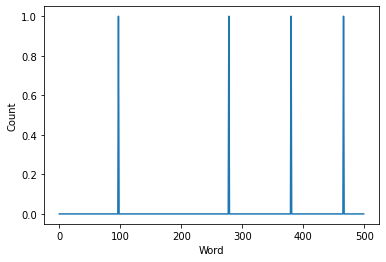

In [ ]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()



In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  42    1  307   66 1726 1119   40 2378    2 1211  205    2  215   32
  155  100   49   69 1068  215   50    3    6  546    3   50 4179    3
 2806    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
#Saving tokenized data
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
#Train & Test Split
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)


Train Set -> (97781, 50) (97781, 3)
Validation Set -> (32594, 50) (32594, 3)
Test Set -> (32594, 50) (32594, 3)


In [ ]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
#Bidirectional LSTM Using NN
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



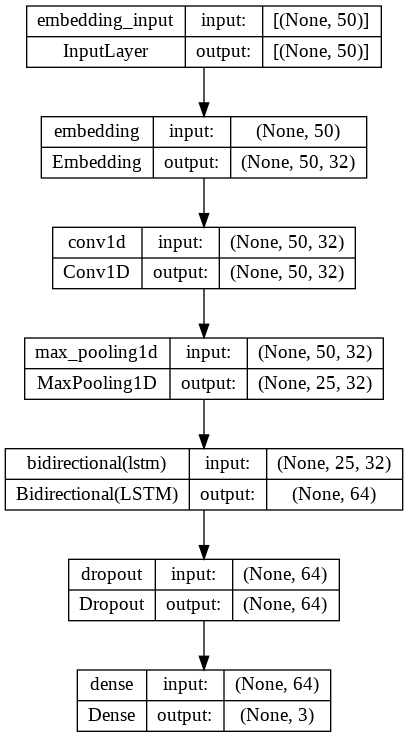

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

In [ ]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8850
Precision : 0.8879
Recall    : 0.8825
F1 Score  : 0.8852


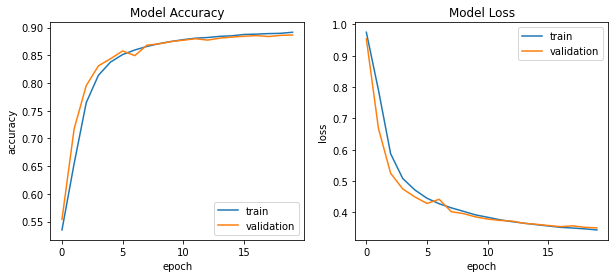

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)


1019/1019 [==============================] - 4s 3ms/step


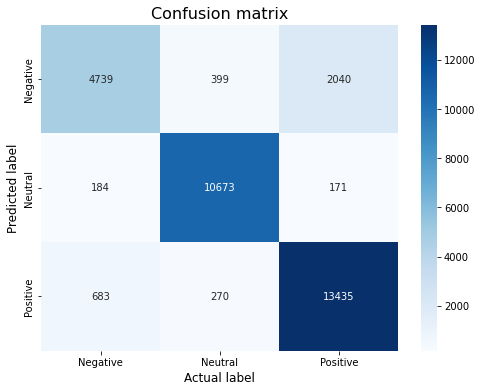

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

In [ ]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [ ]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class(['"I hate when I have to call and wake people up'])

1/1 [==============================] - 1s 664ms/step
The predicted sentiment is Neutral


In [ ]:
predict_class(['The food was meh'])

1/1 [==============================] - 0s 15ms/step
The predicted sentiment is Neutral


In [ ]:
predict_class(['He is a best minister india ever had seen'])

1/1 [==============================] - 0s 15ms/step
The predicted sentiment is Positive
